# todo: add the params to some model names

In [9]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from models.hawkes_model import HawkesModelGeneral, IndHawkesModel
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.plots import DistributionPlotter
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, CellPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
import pickle
from utils.utils import pshape, pmax, pmin, pmean
import os

In [2]:
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_models
from models.baseline_models import ExponentialMovingAverage,\
                UniformMovingAverage, TriangularMovingAverage, HistoricAverage

In [3]:
data_sub_paths = os.listdir("./data/processed")
if '.DS_Store' in data_sub_paths:
    data_sub_paths.remove('.DS_Store')
data_sub_paths

['T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01']

In [4]:
# data_sub_paths = ['T24H-X850M-Y880M_2013-01-01_2015-01-01']

In [5]:
data_sub_path = data_sub_paths[0]
data_path = f"./data/processed/{data_sub_path}/models/"
os.listdir(data_path)

[]

In [14]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")


    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------HAWKES INDEPENDENT MODEL
    conf.model_name = f"Ind-Hawkes Model"  # tod add the actual parameters as well
    conf.model_path = conf.data_path + f"models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = IndHawkesModel(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)


    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES INDEPENDENT MODEL    

2019-11-04T21:21:05 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-04T21:21:05 | root | INFO | 	t_range shape (5841,)
2019-11-04T21:21:07 | root | INFO | =====================================BEGIN=====================================
2019-11-04T21:21:40 | root | INFO | f1_score: 0.32695284327908125 at index 2272782, new threshold 0.07438663958375143
2019-11-04T21:21:45 | root | INFO | 
        MODEL METRICS
            Model Name: Ind-Hawkes Model
                ROC AUC:            0.7377230505054934
                Recall:             0.42706731121365266
                Precision:          0.215363448326808
                Average Precision:  0.23065933127257207
                Accuracy:           0.8149890357507726
                MCC:                0.20808344662649123          
        
2019-11-04T21:21:45 | root | INFO | 
        MODEL RESULT
            Model Name: Ind-Hawkes Model
                ROC AUC:            0.7377230505

2019-11-04T21:25:11 | root | INFO | 
        MODEL METRICS
            Model Name: Ind-Hawkes Model
                ROC AUC:            0.7465972069792866
                Recall:             0.5700498632781084
                Precision:          0.3168706342553786
                Average Precision:  0.36458733001807575
                Accuracy:           0.7368063441834352
                MCC:                0.27368510705509286          
        
2019-11-04T21:25:11 | root | INFO | 
        MODEL RESULT
            Model Name: Ind-Hawkes Model
                ROC AUC:            0.7465972069792866
                Recall:             0.5700498632781084
                Precision:          0.3168706342553786
                Average Precision:  0.36458733001807575
                Accuracy:           0.7368063441834352
                MCC:                0.27368510705509286          
        
2019-11-04T21:25:13 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X425M-Y440M_2013-01-01_

In [6]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")


    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------HAWKES GENERAL MODEL
    conf.model_name = f"Hawkes General Model"  # tod add the actual parameters as well
    conf.model_path = conf.data_path + f"models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = HawkesModelGeneral(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)


    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES GENERAL MODEL    

2019-11-04T20:35:39 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-04T20:35:40 | root | INFO | 	t_range shape (5841,)
2019-11-04T20:35:41 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:35:44 | root | INFO | f1_score: 0.27045810970533996 at index 556007, new threshold 0.03707821162677484
2019-11-04T20:35:49 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                ROC AUC:            0.692342021137089
                Recall:             0.4194682487365414
                Precision:          0.17585960710255408
                Average Precision:  0.18571373285431772
                Accuracy:           0.7787115336263498
                MCC:                0.16147947288398481          
        
2019-11-04T20:35:49 | root | INFO | 
        MODEL RESULT
            Model Name: Hawkes General Model
                ROC AUC:            0.692

2019-11-04T20:36:58 | root | INFO | f1_score: 0.40518633194326237 at index 443053, new threshold 0.04532432500405762
2019-11-04T20:37:01 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                ROC AUC:            0.7131100307428704
                Recall:             0.5535829178060158
                Precision:          0.286268312209526
                Average Precision:  0.3270036912174803
                Accuracy:           0.71019573566753
                MCC:                0.23237236995499605          
        
2019-11-04T20:37:01 | root | INFO | 
        MODEL RESULT
            Model Name: Hawkes General Model
                ROC AUC:            0.7131100307428704
                Recall:             0.5535829178060158
                Precision:          0.286268312209526
                Average Precision:  0.3270036912174803
                Accuracy:           0.71019573566753
                MCC:                0.23237236995499605  

2019-11-04T20:37:49 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-04T20:37:49 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:37:49 | root | INFO | 	t_range shape (5841,)
2019-11-04T20:37:51 | root | INFO | class distribution: {0.0: 0.9053968078535749, 1.0: 0.09460319214642514}


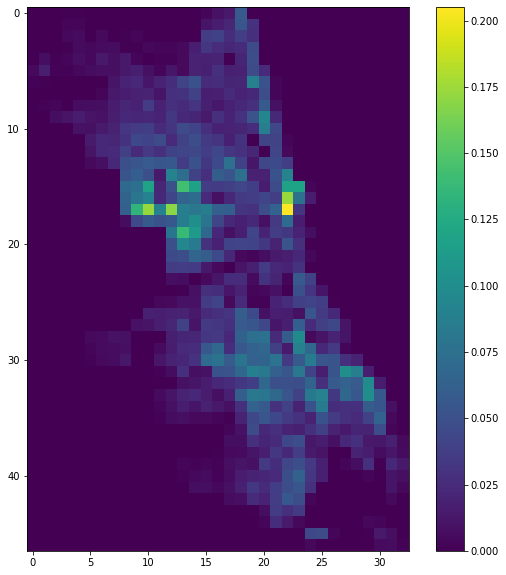

2019-11-04T20:37:51 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:37:51 | root | INFO | using time step: 8
2019-11-04T20:38:05 | root | INFO | f1_score: 0.3210349677785991 at index 255958, new threshold 0.054739466060334856
2019-11-04T20:38:05 | root | INFO | ======== ./data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-04T20:38:09 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7584805238974562
                Recall:             0.4510913352376767
                Precision:          0.22895194193254584
                Average Precision:  0.24669261294567035
                Accuracy:           0.8202738357049424
                MCC:                0.2291997018504875          
        
2019-11-04T20:38:09 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:   

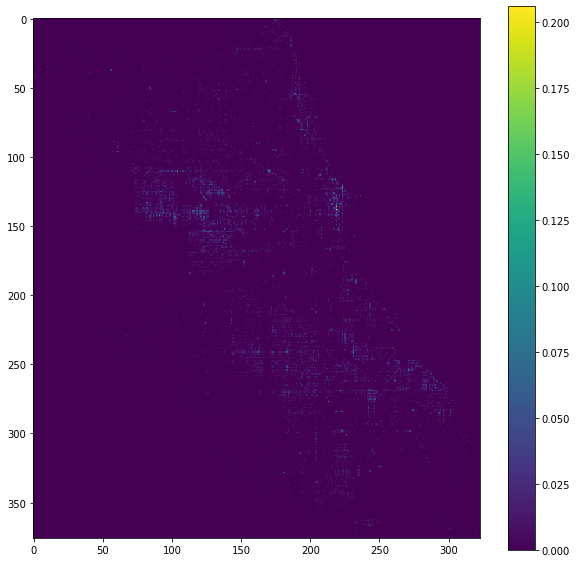

2019-11-04T20:38:55 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:38:55 | root | INFO | using time step: 7
2019-11-04T20:38:59 | root | INFO | f1_score: 0.14840409196899387 at index 1731, new threshold 0.02624498185843081
2019-11-04T20:38:59 | root | INFO | ======== ./data/processed/T24H-X85M-Y110M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-04T20:39:03 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.6634878024528345
                Recall:             0.1938154782020953
                Precision:          0.13215808272842494
                Average Precision:  0.09843613005987162
                Accuracy:           0.9244166758818976
                MCC:                0.1214667077296008          
        
2019-11-04T20:39:03 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:     

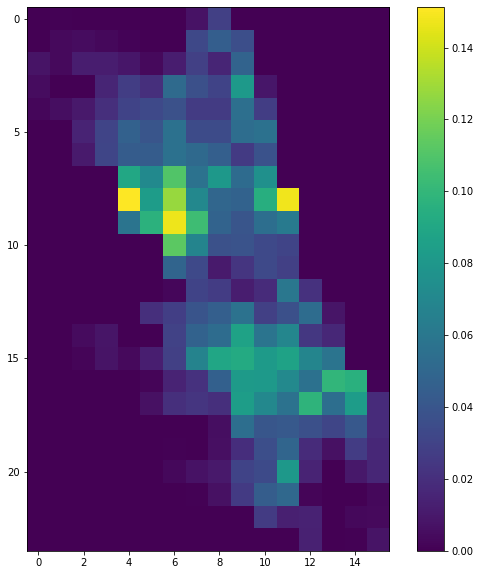

2019-11-04T20:39:50 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:39:50 | root | INFO | using time step: 24
2019-11-04T20:40:05 | root | INFO | f1_score: 0.34762821349340994 at index 263433, new threshold 0.06113686681366697
2019-11-04T20:40:05 | root | INFO | ======== ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/Historic Average/  ========


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-04T20:40:12 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7597608735078295
                Recall:             0.5037929411764706
                Precision:          0.2466478052916294
                Average Precision:  0.2697275659530178
                Accuracy:           0.78995756718529
                MCC:                0.24366977442296392          
        
2019-11-04T20:40:12 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:            0.7597608735078295
                Recall:             0.5037929411764706
                Precision:          0.2466478052916294
                Average Precision:  0.2697275659530178
                Accuracy:           0.78995756718529
                MCC:                0.24366977442296392          
        
2019-11-04T20:40:16 | root | INFO | =====================================END=============================

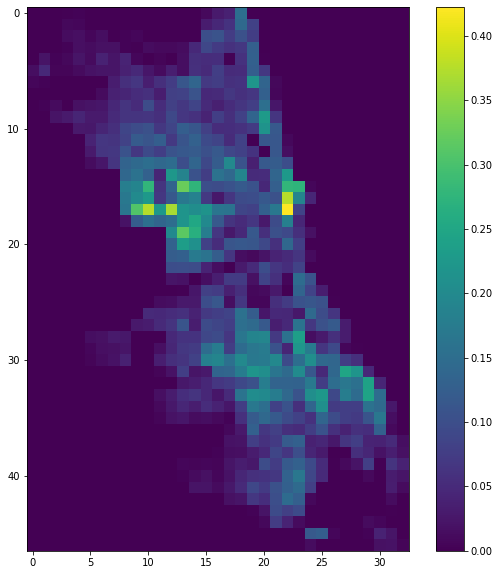

2019-11-04T20:40:53 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:40:53 | root | INFO | using time step: 2
2019-11-04T20:40:55 | root | INFO | f1_score: 0.5865383467265282 at index 239312, new threshold 0.07415678670953608
2019-11-04T20:40:55 | root | INFO | ======== ./data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-04T20:40:56 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7743600401584567
                Recall:             0.7393476687446009
                Precision:          0.45229525523466735
                Average Precision:  0.5709162741220773
                Accuracy:           0.6826685809143523
                MCC:                0.3594183547306032          
        
2019-11-04T20:40:56 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:41:03 | root | INFO | 
        MODEL RESULT
            Model Name: Previous Time Step
                ROC AUC:            0.5850150130321928
                Recall:             1.0
                Precision:          0.2745172186152042
                Average Precision:  0.33614776574698785
                Accuracy:           0.2745172186152042
                MCC:                0.0          
        


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:41:05 | root | INFO | =====================================END=====================================

2019-11-04T20:41:05 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X255M-Y220M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-04T20:41:05 | root | INFO | =====================================BEGIN=====================================


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:41:05 | root | INFO | 	t_range shape (731,)
2019-11-04T20:41:07 | root | INFO | class distribution: {0.0: 0.9108108441991151, 1.0: 0.08918915580088496}


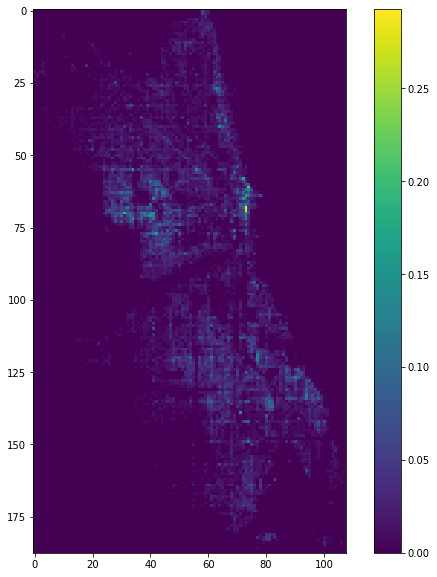

2019-11-04T20:41:07 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:41:07 | root | INFO | using time step: 7
2019-11-04T20:41:09 | root | INFO | f1_score: 0.2591082538455392 at index 3962, new threshold 0.03857257866179444
2019-11-04T20:41:09 | root | INFO | ======== ./data/processed/T24H-X255M-Y220M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-04T20:41:12 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.6981179773333572
                Recall:             0.3702053699856161
                Precision:          0.2012576567183631
                Average Precision:  0.2023992037657783
                Accuracy:           0.8282058325321613
                MCC:                0.18338856170647114          
        
2019-11-04T20:41:12 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:      

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:41:37 | root | INFO | 
        MODEL RESULT
            Model Name: Previous Time Step
                ROC AUC:            0.5373107957840094
                Recall:             1.0
                Precision:          0.08184380743095206
                Average Precision:  0.09497672532939426
                Accuracy:           0.08184380743095206
                MCC:                0.0          
        


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:41:41 | root | INFO | =====================================END=====================================

2019-11-04T20:41:41 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T6H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-04T20:41:41 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:41:42 | root | INFO | 	t_range shape (2921,)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:41:42 | root | INFO | class distribution: {0.0: 0.8280142426889008, 1.0: 0.17198575731109927}


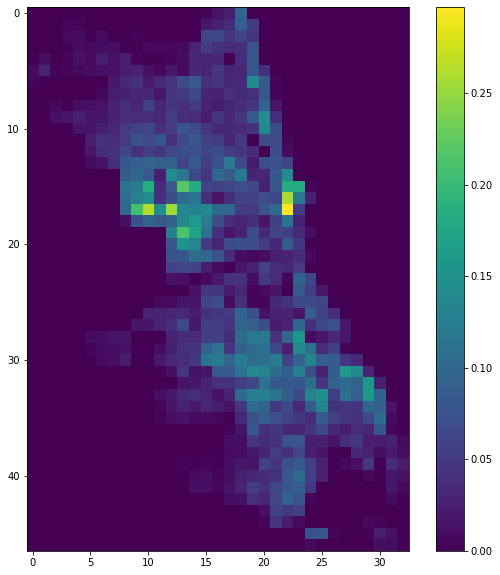

2019-11-04T20:41:43 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:41:43 | root | INFO | using time step: 4
2019-11-04T20:41:47 | root | INFO | f1_score: 0.44496971558567466 at index 321662, new threshold 0.06408993340449537
2019-11-04T20:41:47 | root | INFO | ======== ./data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-04T20:41:49 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7624706649770113
                Recall:             0.5883866816792666
                Precision:          0.33048741925283465
                Average Precision:  0.39024410251694613
                Accuracy:           0.745581911676513
                MCC:                0.2950861211771935          
        
2019-11-04T20:41:49 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:42:04 | root | INFO | 
        MODEL RESULT
            Model Name: Previous Time Step
                ROC AUC:            0.5613982224556262
                Recall:             1.0
                Precision:          0.15865562516747267
                Average Precision:  0.1918503791867989
                Accuracy:           0.15865562516747267
                MCC:                0.0          
        


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:42:07 | root | INFO | =====================================END=====================================

2019-11-04T20:42:07 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X425M-Y440M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-04T20:42:07 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:42:07 | root | INFO | 	t_range shape (731,)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:42:08 | root | INFO | class distribution: {0.0: 0.8006992927452359, 1.0: 0.19930070725476412}


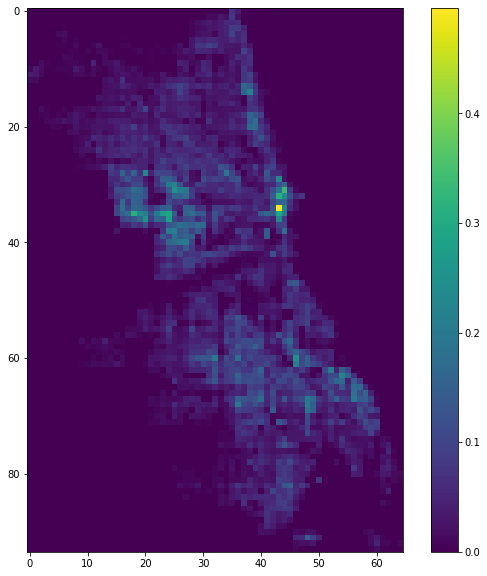

2019-11-04T20:42:08 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:42:08 | root | INFO | using time step: 7
2019-11-04T20:42:09 | root | INFO | f1_score: 0.4423115074444764 at index 9071, new threshold 0.0601041229758661
2019-11-04T20:42:09 | root | INFO | ======== ./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-04T20:42:10 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.733281614607318
                Recall:             0.5982652314766433
                Precision:          0.33451757666417353
                Average Precision:  0.4028633694613936
                Accuracy:           0.707615472022603
                MCC:                0.2724687798587759          
        
2019-11-04T20:42:10 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:         

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:42:21 | root | INFO | 
        MODEL RESULT
            Model Name: Previous Time Step
                ROC AUC:            0.5714320190902771
                Recall:             1.0
                Precision:          0.18366884712241263
                Average Precision:  0.22997611878946467
                Accuracy:           0.18366884712241263
                MCC:                0.0          
        


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:42:23 | root | INFO | =====================================END=====================================

2019-11-04T20:42:23 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-04T20:42:23 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:42:23 | root | INFO | 	t_range shape (731,)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:42:24 | root | INFO | class distribution: {0.0: 0.5351816556679277, 1.0: 0.46481834433207225}


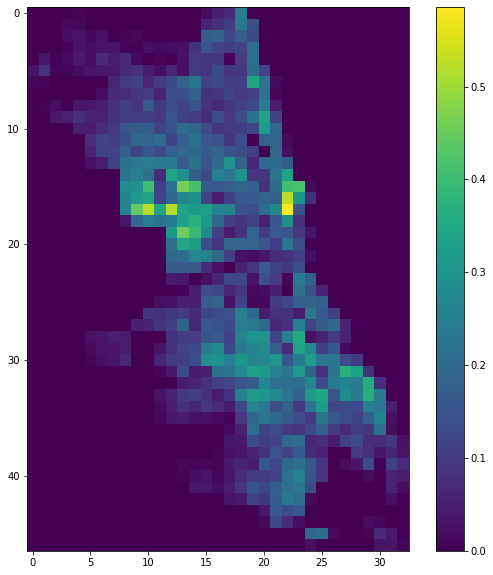

2019-11-04T20:42:24 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:42:24 | root | INFO | using time step: 7
2019-11-04T20:42:24 | root | INFO | f1_score: 0.7213488600737173 at index 10948, new threshold 0.08097721274085151
2019-11-04T20:42:24 | root | INFO | ======== ./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-04T20:42:25 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7928984398072798
                Recall:             0.8705484641837151
                Precision:          0.5906358747231889
                Average Precision:  0.7478699597393421
                Accuracy:           0.6761706073249885
                MCC:                0.4093492564232235          
        
2019-11-04T20:42:25 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:      

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:42:29 | root | INFO | =====================================END=====================================

2019-11-04T20:42:29 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T1H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-04T20:42:29 | root | INFO | =====================================BEGIN=====================================


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-04T20:42:30 | root | INFO | 	t_range shape (17521,)
2019-11-04T20:42:34 | root | INFO | class distribution: {0.0: 0.9658681720565496, 1.0: 0.03413182794345039}


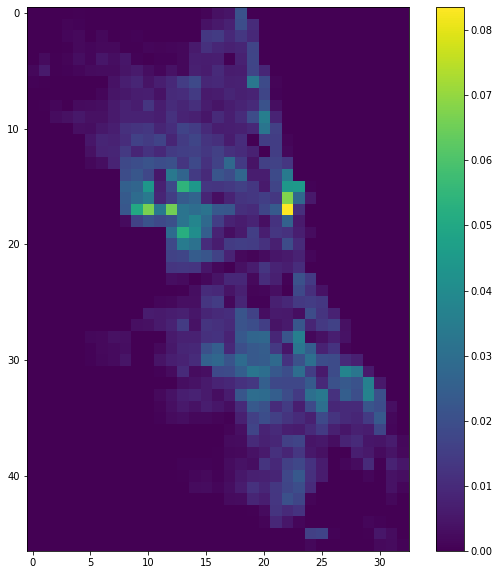

2019-11-04T20:42:34 | root | INFO | =====================================BEGIN=====================================
2019-11-04T20:42:34 | root | INFO | using time step: 24
2019-11-04T20:43:32 | root | INFO | f1_score: 0.16422192920815143 at index 117908, new threshold 0.03009961890086329
2019-11-04T20:43:32 | root | INFO | ======== ./data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-04T20:43:46 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7520671642683804
                Recall:             0.2558226513889361
                Precision:          0.11607886698139405
                Average Precision:  0.10136488884611894
                Accuracy:           0.9161259979640844
                MCC:                0.13272275754567311          
        
2019-11-04T20:43:46 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:            0.7520671642683804
                Recall:             0.2558226513889361
                Precision:          0.11607886698139405
                Average Precision:  0.10136488884611894
                Accuracy:           0.9161259979640844
                MCC:                0.13272275754567311          
        
2019-11-04T20:44:01 | root | INFO | =====================================END=====================

In [7]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
  
    conf.data_path = f"./data/processed/{data_sub_path}/"
    
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "===t==================================================")

    log.info("=====================================BEGIN=====================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)

    conf.shaper_threshold = 0
    conf.shaper_top_k = -1

    # CRIME DATA
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
    
    # LOG CLASS DISTRIBUTION
    vals, counts = np.unique(data_group.targets,return_counts=True)
    counts = counts/np.sum(counts)
    dist = dict(zip(vals,counts))
    log.info(f"class distribution: {dist}")

    test_set_size = data_group.testing_set.target_shape[0]
    crimes = data_group.shaper.unsqueeze(data_group.crimes)
    im(crimes.mean(0)[0])
    crimes = data_group.crimes
    t_range = data_group.t_range

    # -----------HISTORIC AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Historic Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    # time step in this context is used for 
    freqstr = t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))
    if time_step == 1:
        time_step = 7  # historic average to a week when time scale is daily

    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    ha = HistoricAverage(step=time_step)
    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_crimes_ha = ha(all_crimes)
    all_t_range = data_group.t_range

    tst_crimes_ha = all_crimes_ha[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_crimes_ha[time_step+1:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[time_step+1:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_probas_pred = tst_crimes_ha
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------HISTORIC AVERAGE

    # -----------GLOBAL AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Global Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets

    trn_crimes = all_crimes[:-test_set_size]
    trn_targets = all_targets[:-test_set_size]

    tst_crimes = all_crimes[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_mean = np.mean(trn_crimes,axis=0,keepdims=True)  # keep dims used to make scalar product easy
    trn_ones = np.ones_like(trn_crimes,dtype=np.float)
    trn_probas_pred = trn_mean*trn_ones

    thresh = best_threshold(y_true=trn_targets,
                            probas_pred=trn_probas_pred) # should only come from the train predictions

    # only use the training sets - mean
    tst_ones = np.ones_like(tst_crimes,dtype=np.float)
    tst_probas_pred = trn_mean*tst_ones

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------GLOBAL AVERAGE


    # ------------ROLLING AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Rolling Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")



    # time step in this context is used for 
    freqstr = t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))
    if time_step == 1:
        time_step = 7  # historic average to a week when time scale is daily

    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    alpha=1e-2
    window_len=time_step

    ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)

    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_probas_pred = ma(all_crimes)
    all_t_range = data_group.t_range

    tst_probas_pred = all_probas_pred[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[time_step+1:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_probas_pred = tst_probas_pred
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # ------------ROLLING AVERAGE
    
    
    # ------------PREVIOUS TIME STEP
    # Create model folder and setup logging for model
    conf.model_name = "Previous Time Step"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_probas_pred = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_t_range = data_group.t_range

    tst_probas_pred = all_probas_pred[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_probas_pred[:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)
    
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # ------------PREVIOUS TIME STEP

2019-11-04T21:46:52 | root | INFO | T3H-X850M-Y880M_2013-01-01_2015-01-01



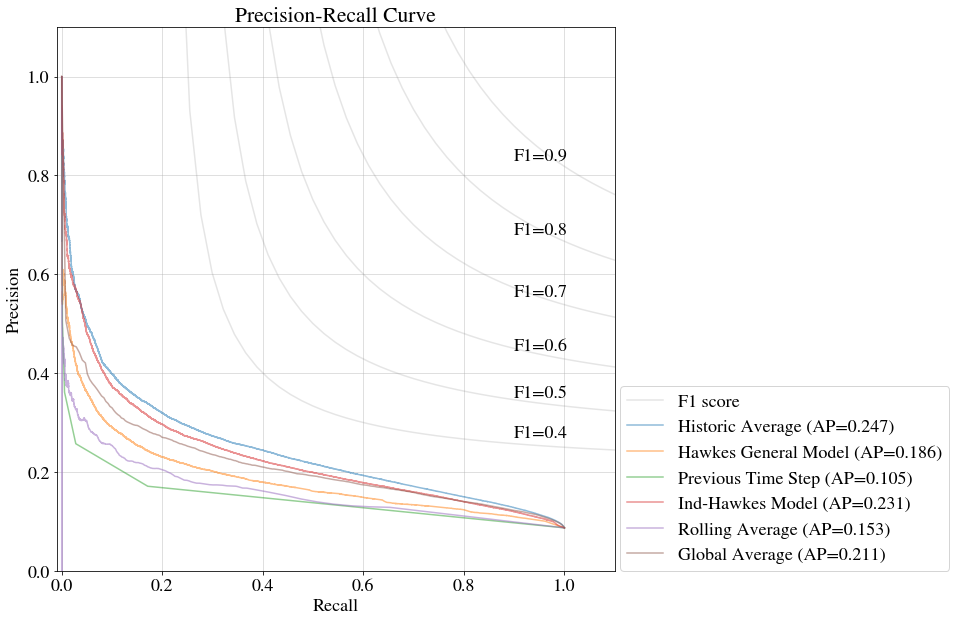

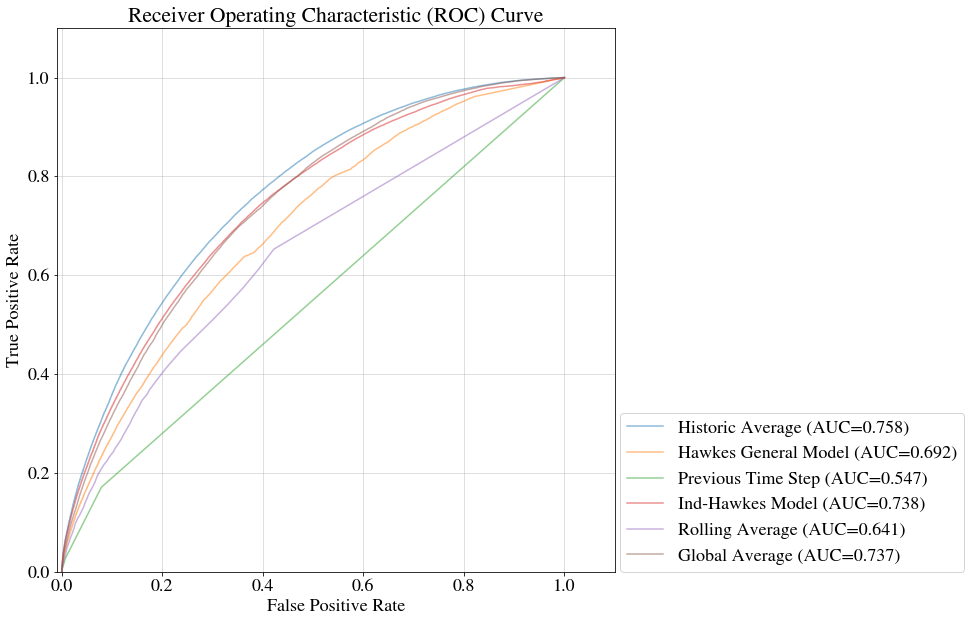

2019-11-04T21:46:53 | root | INFO | T24H-X85M-Y110M_2013-01-01_2015-01-01



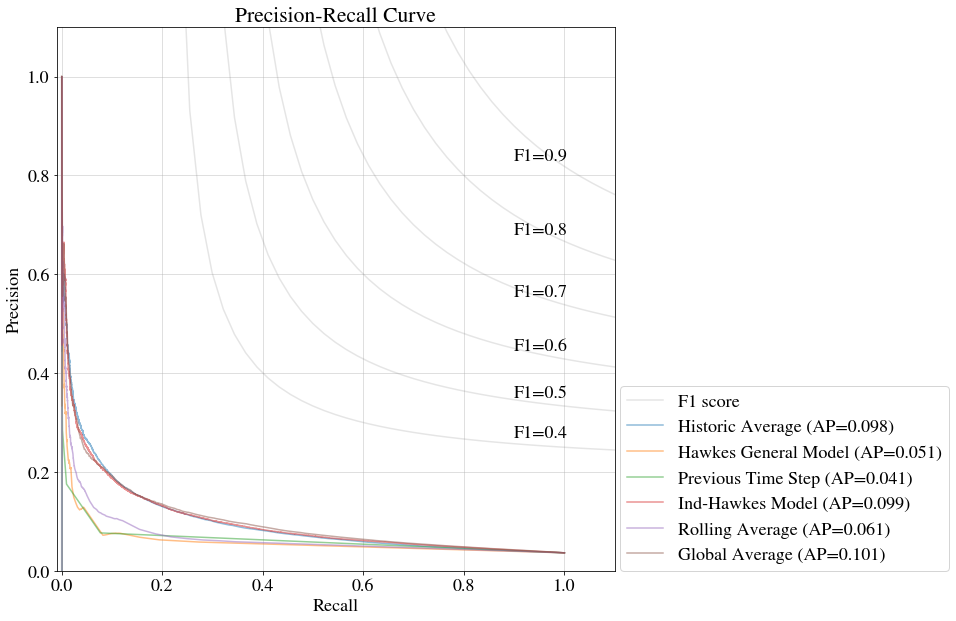

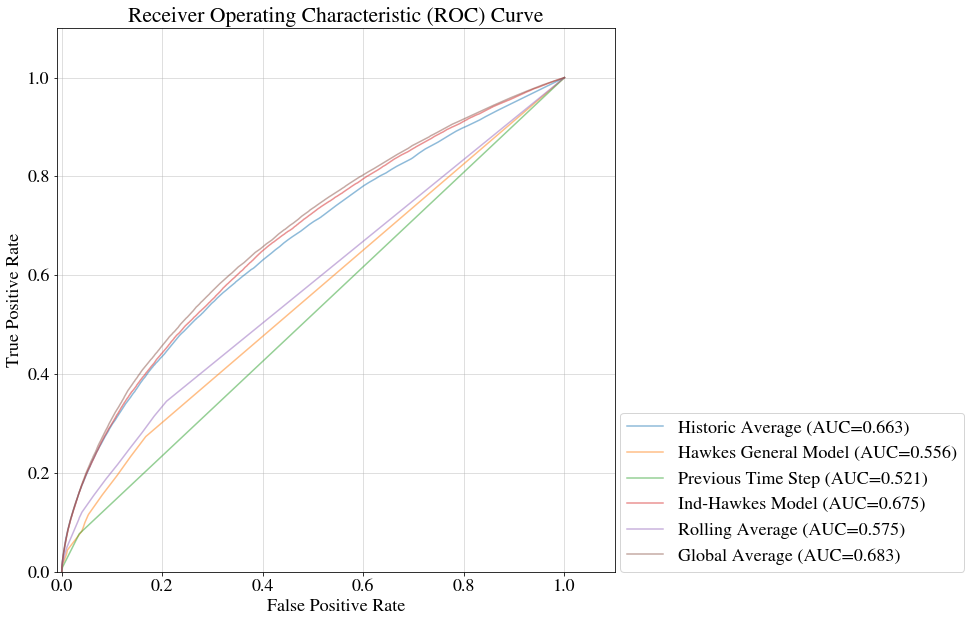

2019-11-04T21:46:54 | root | INFO | T1H-X1700M-Y1760M_2013-01-01_2015-01-01



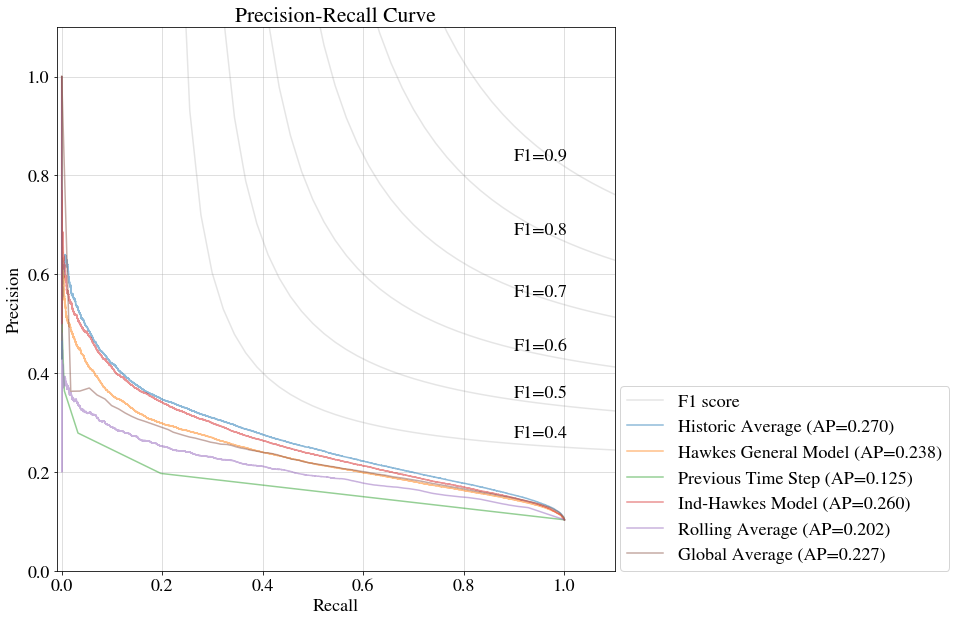

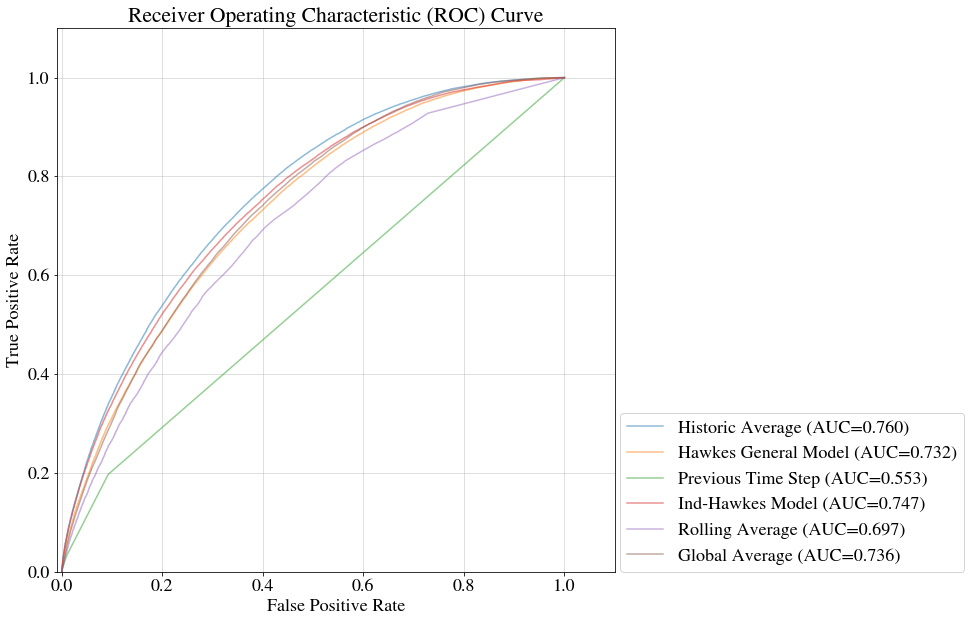

2019-11-04T21:46:55 | root | INFO | T12H-X850M-Y880M_2013-01-01_2015-01-01



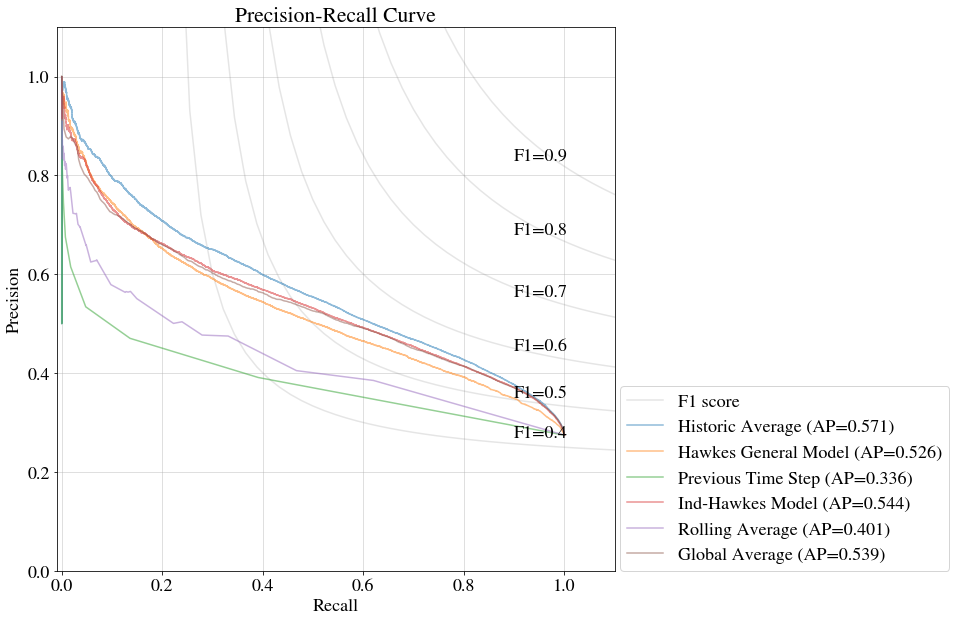

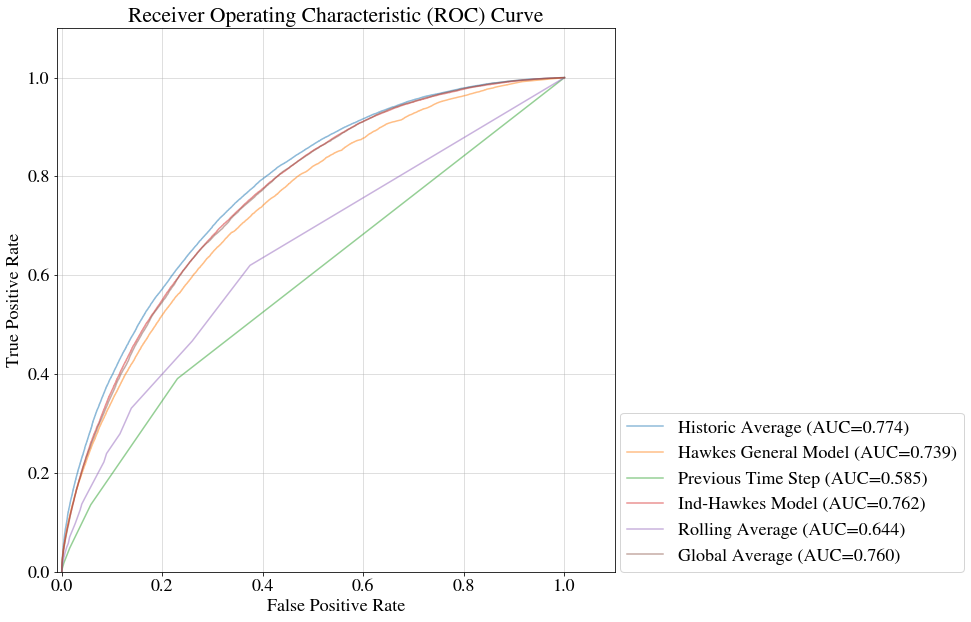

2019-11-04T21:46:56 | root | INFO | T24H-X255M-Y220M_2013-01-01_2015-01-01



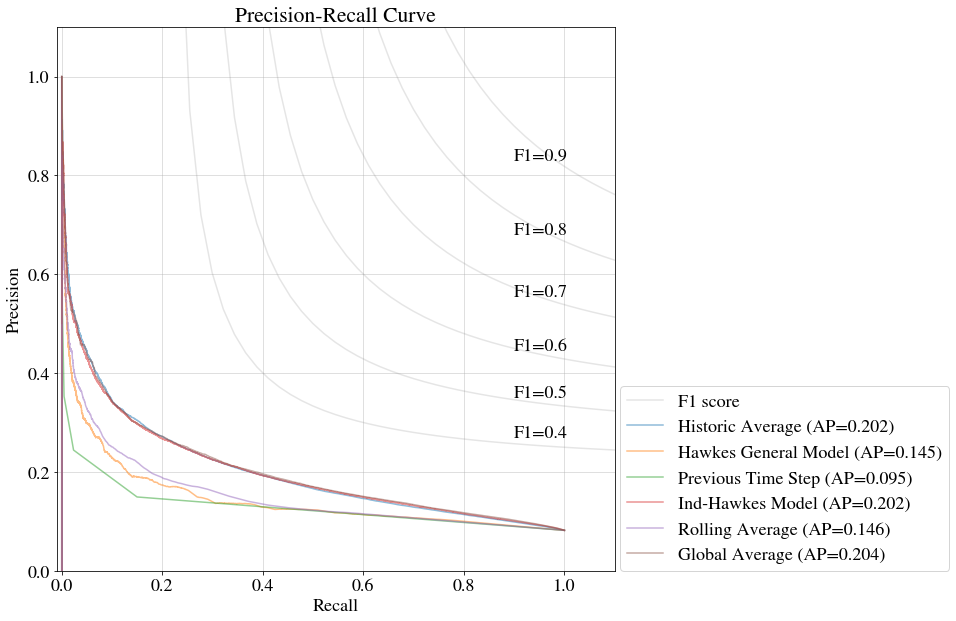

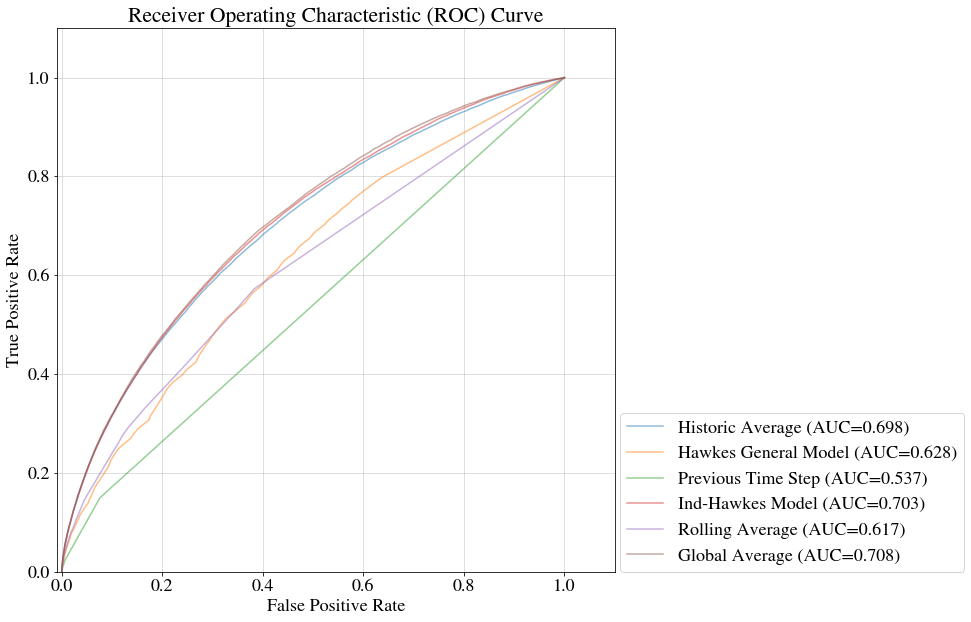

2019-11-04T21:46:57 | root | INFO | T6H-X850M-Y880M_2013-01-01_2015-01-01



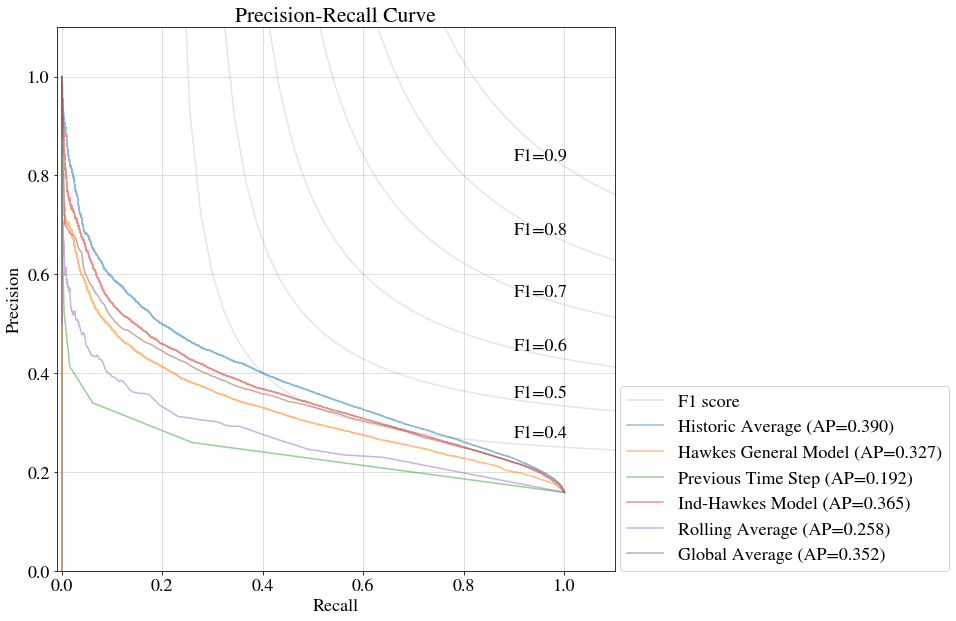

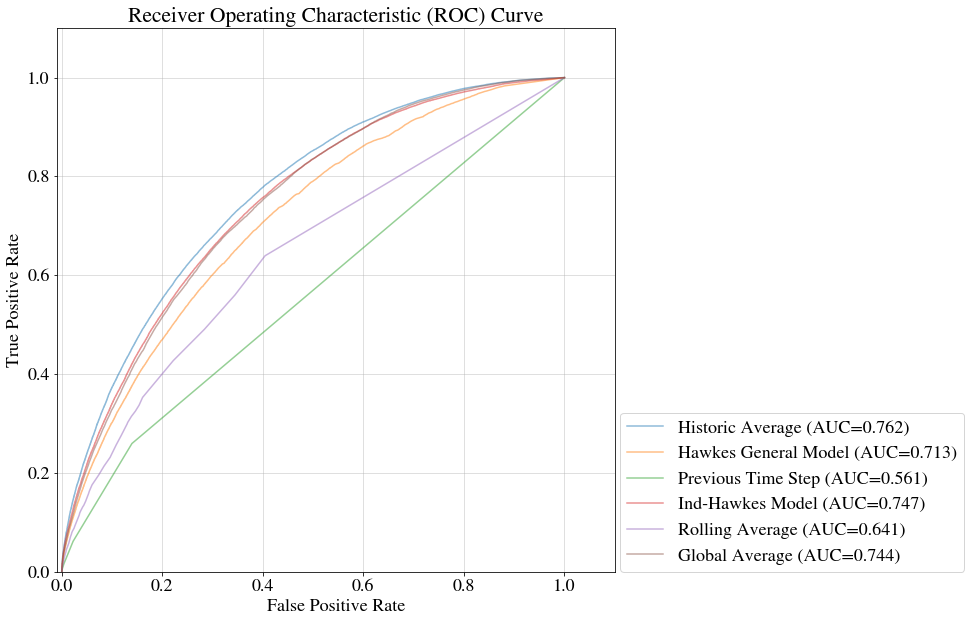

2019-11-04T21:46:57 | root | INFO | T24H-X425M-Y440M_2013-01-01_2015-01-01



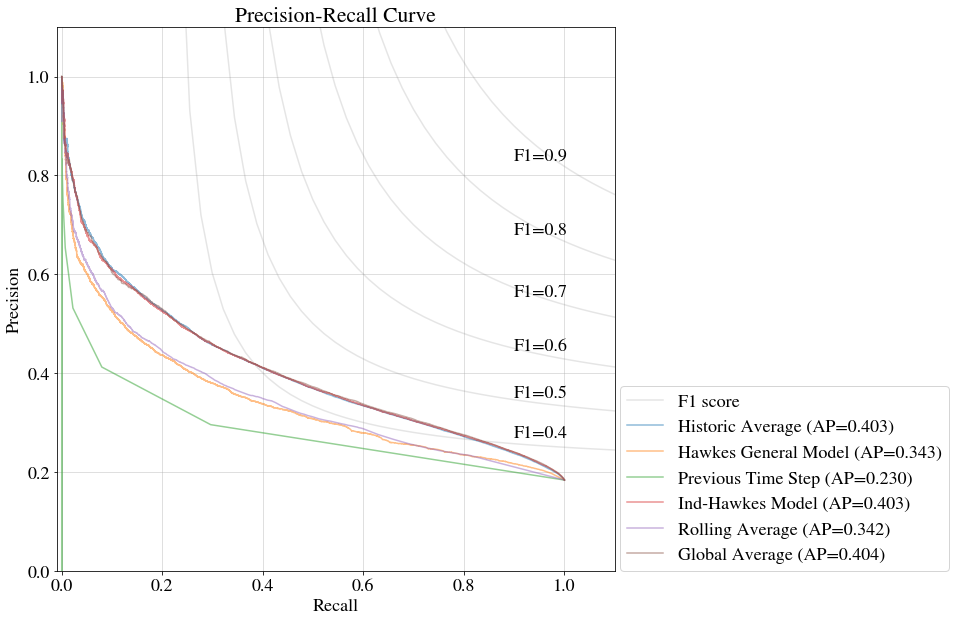

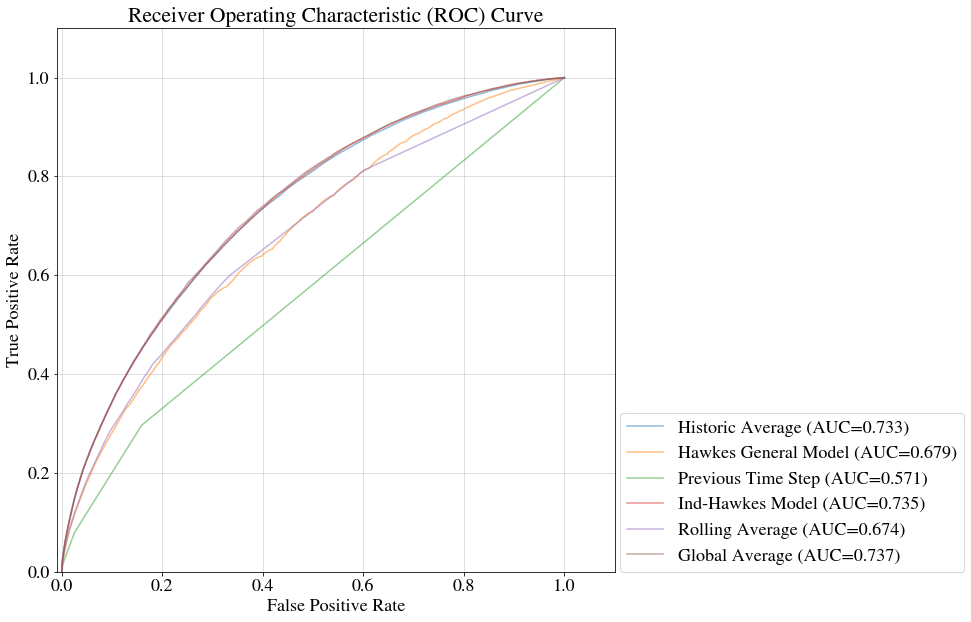

2019-11-04T21:46:58 | root | INFO | T24H-X850M-Y880M_2013-01-01_2015-01-01



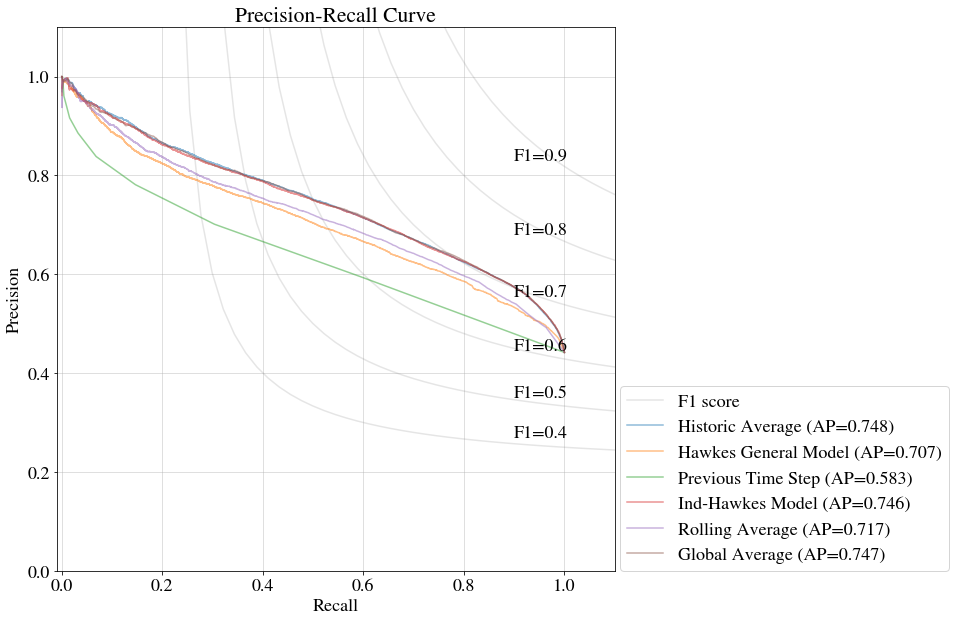

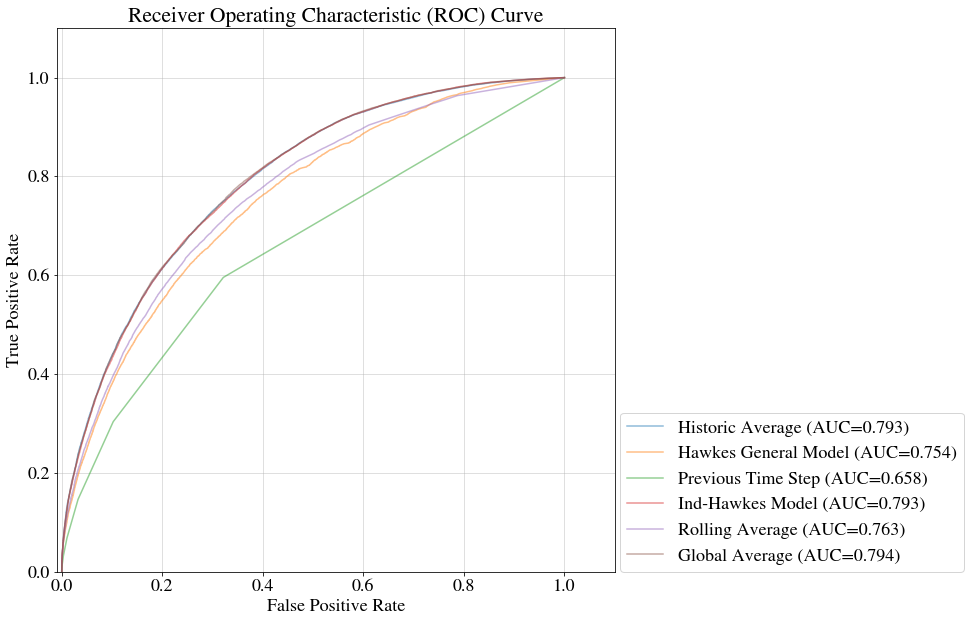

2019-11-04T21:46:59 | root | INFO | T1H-X850M-Y880M_2013-01-01_2015-01-01



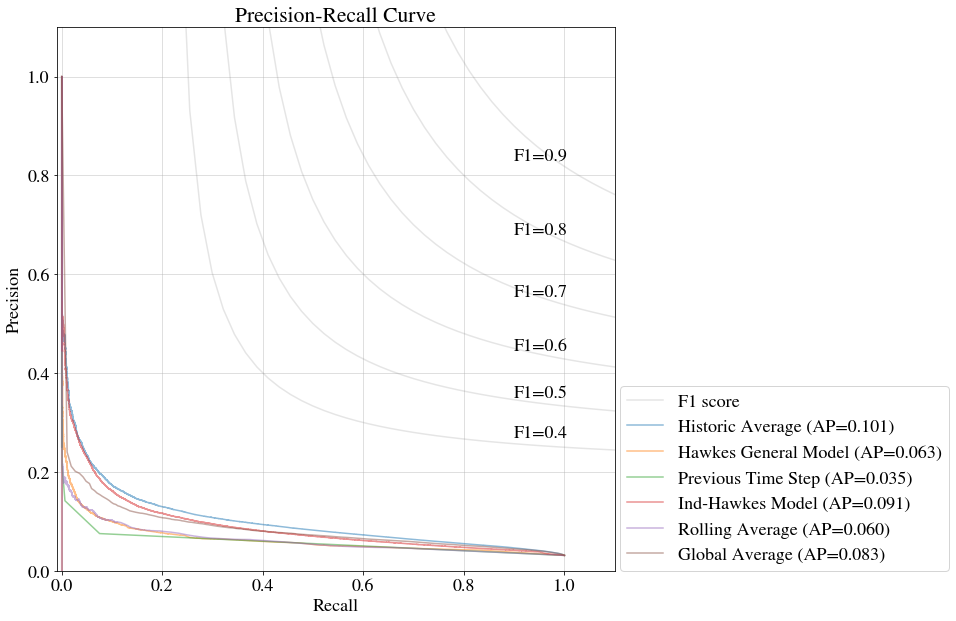

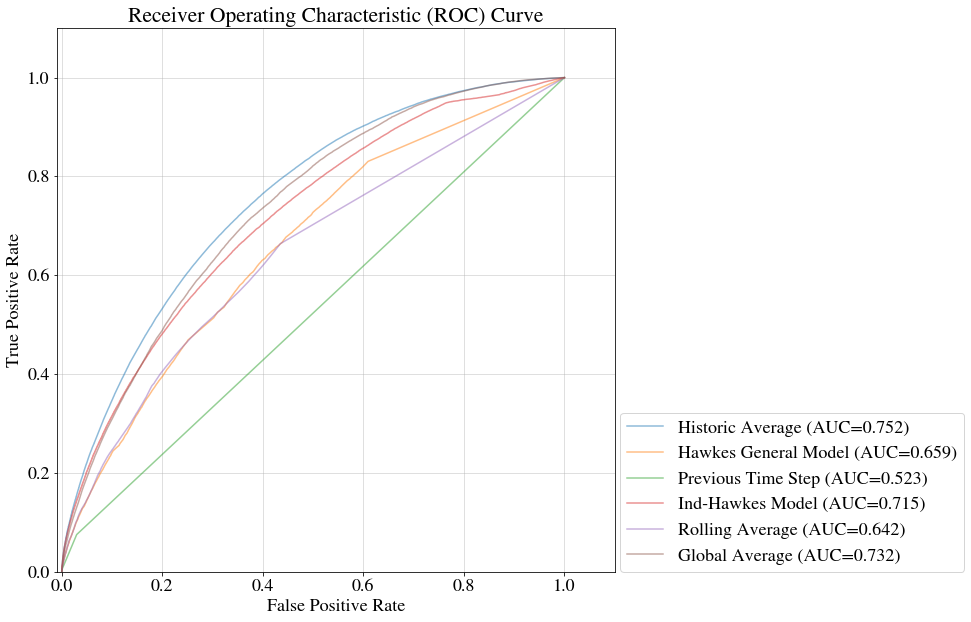

In [15]:
data_path = conf.model_path[:conf.model_path.find("models")]
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    compare_models(data_path)

In [14]:
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  "T3H-X850M-Y880M" # needs to exist
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

model_name = "test-logging-change"  # needs to be created
model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")


if not os.path.exists(data_path):
    raise Exception(f"Directory ({data_path}) needs to exist.")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": False,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.3,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
info["device"] = device.type
conf.device = device

2019-11-02T20:01:55 | root | INFO | =====================================BEGIN=====================================


2019-11-02T20:02:03 | root | INFO | 	t_range shape (731,)
threshold: -1 - targets.shape: (729, 1, 770)
class distribution: {0.0: 0.564881620437176, 1.0: 0.435118379562824}


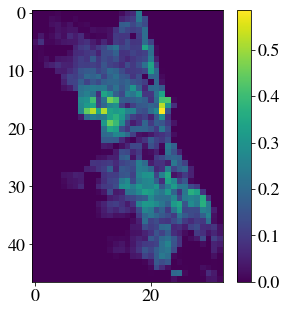

In [15]:
# visualize the cells that we are dropping
conf.shaper_threshold = 0
conf.shaper_top_k = -1

for i in [-1]:
    conf.shaper_top_k = i
    data_group = FlatDataGroup(data_path=data_path, conf=conf)
    print(f"threshold: {i} - targets.shape: {data_group.targets.shape}")
    vals, counts = np.unique(data_group.targets,return_counts=True)
    counts = counts/np.sum(counts)
    dist = dict(zip(vals,counts))
    print(f"class distribution: {dist}")
    
    sorted_indices = data_group.sorted_indices
    
    plt.figure(figsize=(5,5))
    plt.imshow(data_group.shaper.unsqueeze(data_group.crimes)[:,0].mean(0))
    plt.colorbar()
    plt.show()

In [9]:
conf.shaper_threshold = 0
conf.shaper_top_k = -1

# CRIME DATA
data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

2019-11-01T23:08:43 | root | INFO | 	t_range shape (5841,)


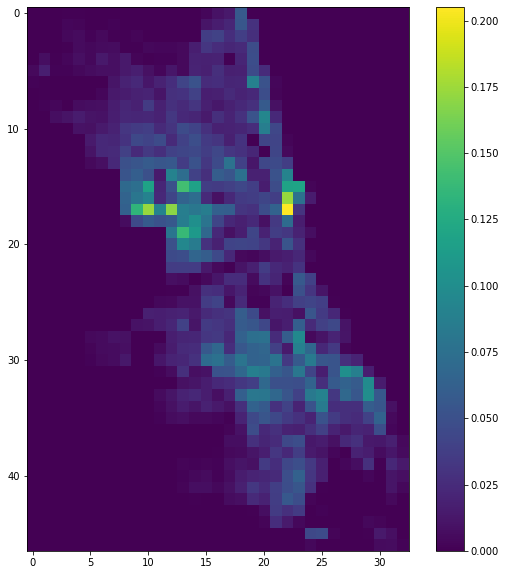

In [10]:
test_set_size = data_group.testing_set.target_shape[0]
crimes = data_group.shaper.unsqueeze(data_group.crimes)
im(crimes.mean(0)[0])
crimes = data_group.crimes
t_range = data_group.t_range

In [11]:
model_results = []

## Historic average model

In [12]:
log.getLogger().setLevel("INFO")

2019-11-01T23:08:46 | root | INFO | =====================================BEGIN=====================================
2019-11-01T23:08:46 | root | INFO | Device: cpu
2019-11-01T23:08:46 | root | INFO | using time step: 8
2019-11-01T23:09:03 | root | INFO | f1_score: 0.32086375587433447 at index 256352, new threshold 0.054739466060334856
2019-11-01T23:09:05 | root | INFO | 
        MODEL METRICS
            Model Name: historic-average
                ROC AUC:            0.774823608825903
                Recall:             0.4505241626182562
                Precision:          0.2288715079652258
                Average Precision:  0.24636050236966572
                Accuracy:           0.8319866419294991
                MCC:                0.23573266614942093          
        
2019-11-01T23:09:05 | root | INFO | 
        MODEL RESULT
            Model Name: historic-average
                ROC AUC:            0.774823608825903
                Recall:             0.4505241626182562
     

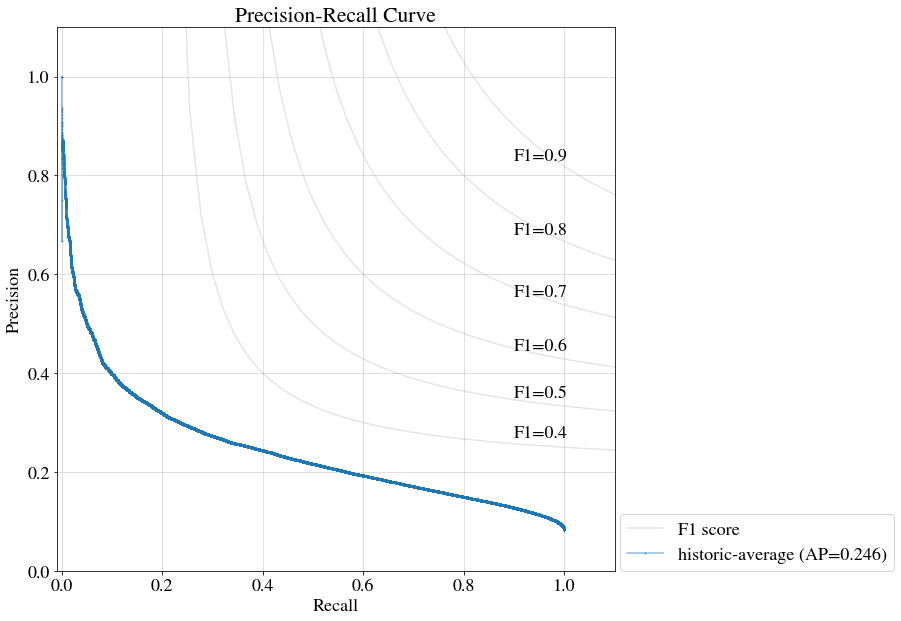

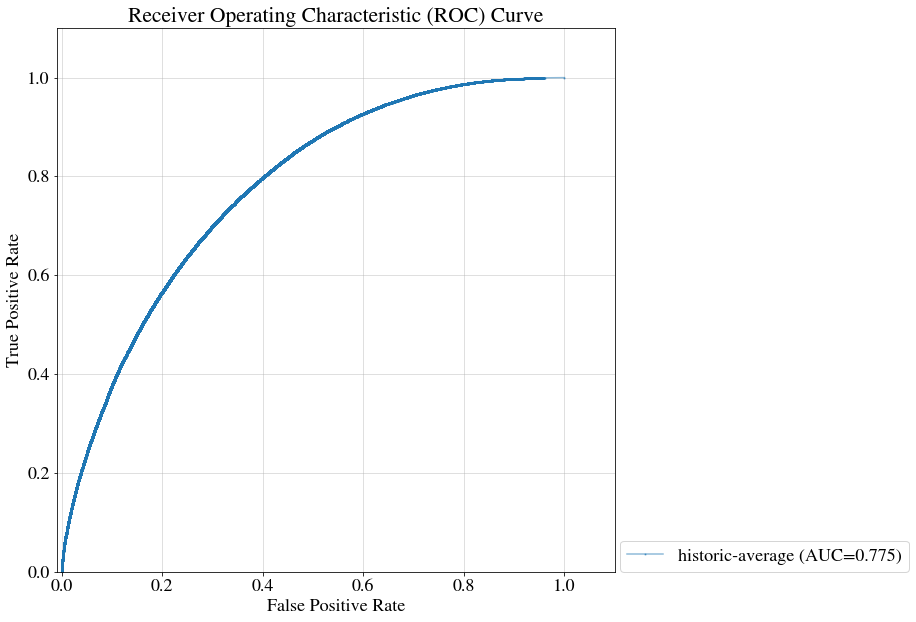

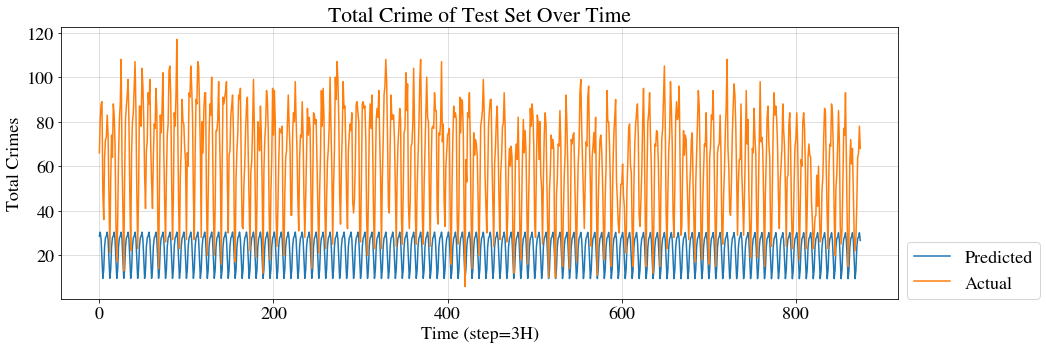

In [13]:
# Create model folder and setup logging for model
model_name = "Historic Average"  # needs to be created
conf.model_name = model_name
model_path = data_path + f"models/{model_name}/"
conf.model_path = model_path
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")



# time step in this context is used for 
freqstr = t_range.freqstr
if freqstr == "H":
    freqstr = "1H"
time_step = int(24 / int(freqstr[:freqstr.find("H")]))
if time_step == 1:
    time_step = 7  # historic average to a week when time scale is daily

log.info(f"using time step: {time_step}")

test_set_size = data_group.testing_set.target_shape[0]

ha = HistoricAverage(step=time_step)
all_crimes = data_group.crimes[:,0]
all_targets = data_group.targets
all_crimes_ha = ha(all_crimes)
all_t_range = data_group.t_range

tst_crimes_ha = all_crimes_ha[-test_set_size:]
tst_targets = all_targets[-test_set_size:]
tst_t_range = all_t_range[-test_set_size:]

trn_probas_pred = all_crimes_ha[time_step+1:-test_set_size] # skip all the nan values
trn_y_true = all_targets[time_step+1:-test_set_size]

thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

tst_y_true = tst_targets
tst_probas_pred = tst_crimes_ha
tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)  


log.info("=====================================END=====================================")

## Mean of training data as future prediction

2019-11-01T23:09:14 | root | INFO | =====================================BEGIN=====================================
2019-11-01T23:09:14 | root | INFO | Device: cpu
2019-11-01T23:09:15 | root | INFO | f1_score: 0.30090412094082986 at index 568, new threshold 0.04827181174859595
2019-11-01T23:09:17 | root | INFO | 
        MODEL METRICS
            Model Name: mean-model
                ROC AUC:            0.7548274166935257
                Recall:             0.4849873981809548
                Precision:          0.19454212454212455
                Average Precision:  0.2110477182079281
                Accuracy:           0.7949625231910946
                MCC:                0.20895730172305532          
        
2019-11-01T23:09:17 | root | INFO | 
        MODEL RESULT
            Model Name: mean-model
                ROC AUC:            0.7548274166935257
                Recall:             0.4849873981809548
                Precision:          0.19454212454212455
                Av

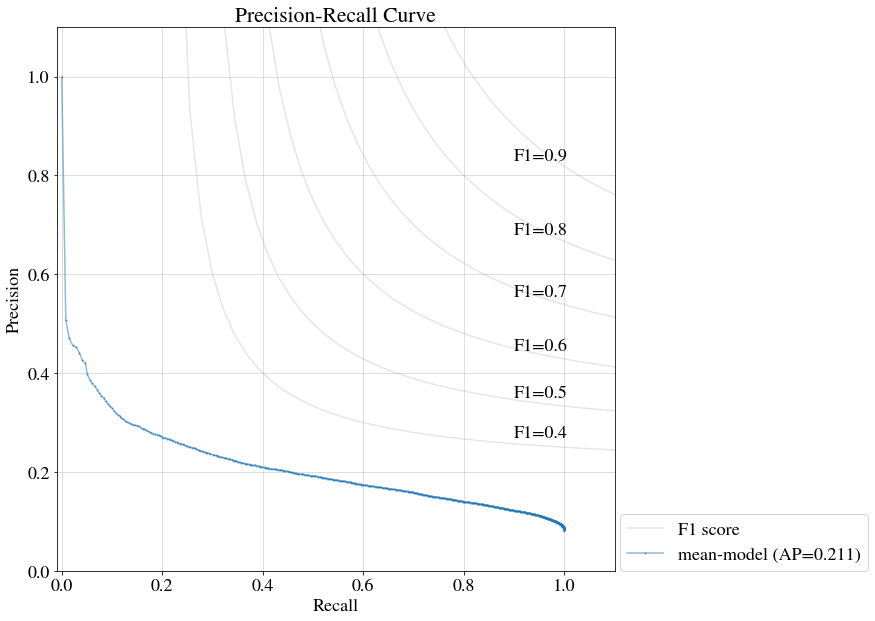

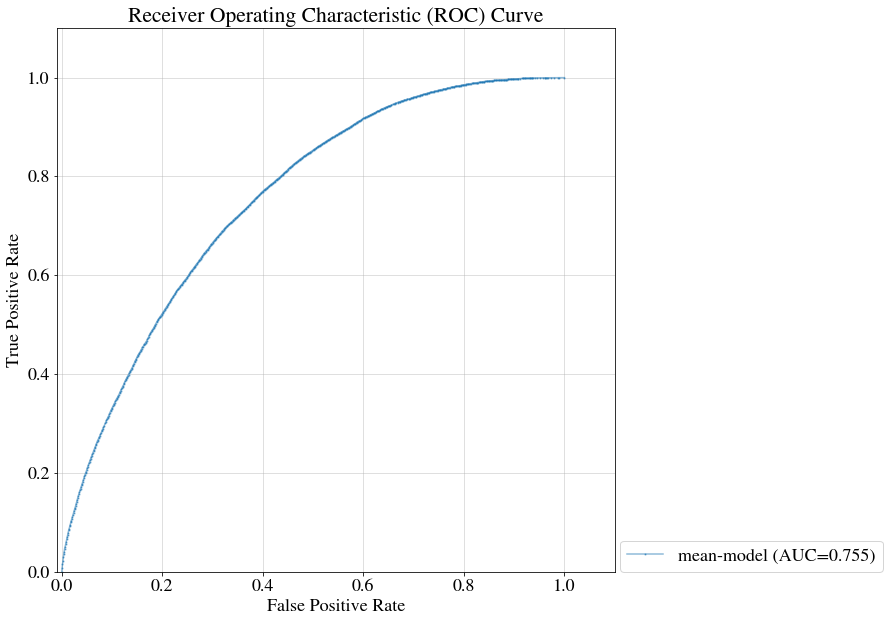

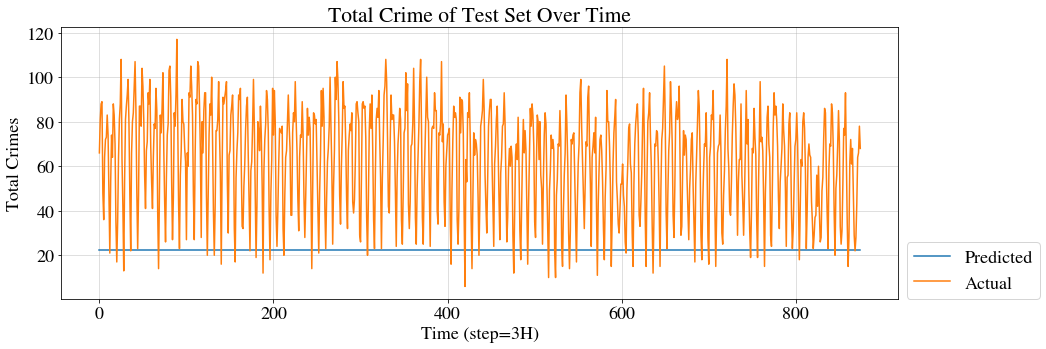

In [14]:
# Create model folder and setup logging for model
model_name = "Train Average"  # needs to be created
conf.model_name = model_name
model_path = data_path + f"models/{model_name}/"
conf.model_path = model_path
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")


test_set_size = data_group.testing_set.target_shape[0]

all_crimes = data_group.crimes[:,0]
all_targets = data_group.targets

trn_crimes = all_crimes[:-test_set_size]
trn_targets = all_targets[:-test_set_size]

tst_crimes = all_crimes[-test_set_size:]
tst_targets = all_targets[-test_set_size:]
tst_t_range = all_t_range[-test_set_size:]

trn_mean = np.mean(trn_crimes,axis=0,keepdims=True)  # keep dims used to make scalar product easy
trn_ones = np.ones_like(trn_crimes,dtype=np.float)
trn_probas_pred = trn_mean*trn_ones

thresh = best_threshold(y_true=trn_targets,
                        probas_pred=trn_probas_pred) # should only come from the train predictions

# only use the training sets - mean
tst_ones = np.ones_like(tst_crimes,dtype=np.float)
tst_probas_pred = trn_mean*tst_ones

tst_y_true = tst_targets
tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)
    
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)  

log.info("=====================================END=====================================")

## Rolling mean of all data 

2019-11-01T23:09:25 | root | INFO | =====================================BEGIN=====================================
2019-11-01T23:09:25 | root | INFO | Device: cpu
2019-11-01T23:09:25 | root | INFO | using time step: 8
2019-11-01T23:09:26 | root | INFO | f1_score: 0.18450185579413678 at index 1, new threshold 0.3010299956639812
2019-11-01T23:09:28 | root | INFO | 
        MODEL METRICS
            Model Name: Rolling Average
                ROC AUC:            0.5491959494110937
                Recall:             0.170909887862074
                Precision:          0.17085995983202484
                Average Precision:  0.09990056031060694
                Accuracy:           0.8652200371057513
                MCC:                0.09753293569953783          
        
2019-11-01T23:09:28 | root | INFO | 
        MODEL RESULT
            Model Name: Rolling Average
                ROC AUC:            0.5491959494110937
                Recall:             0.170909887862074
             

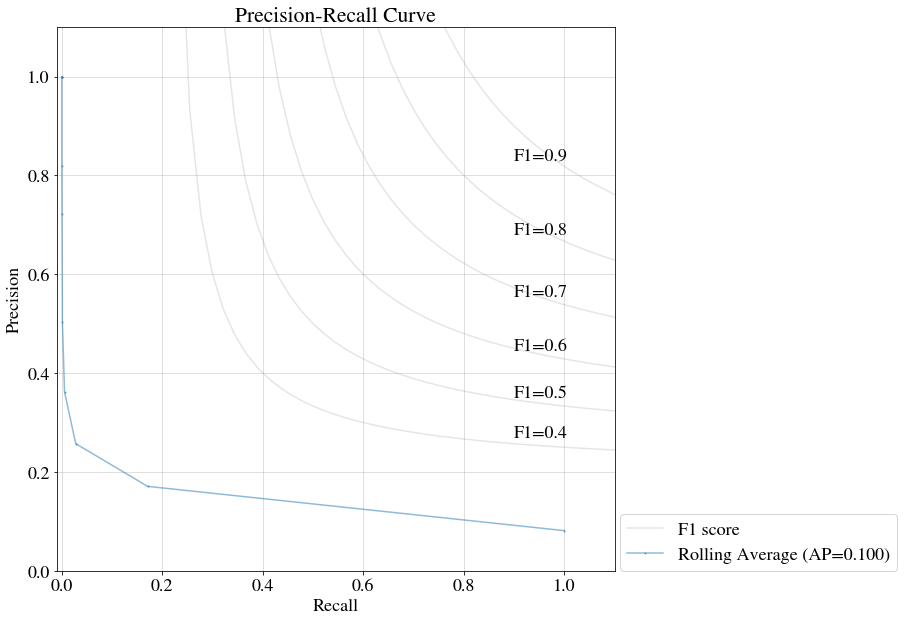

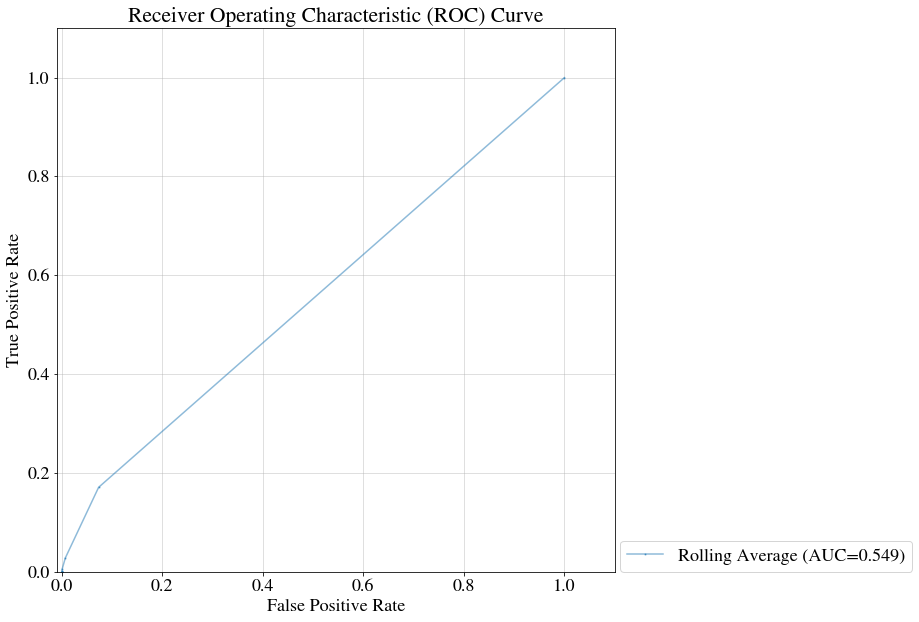

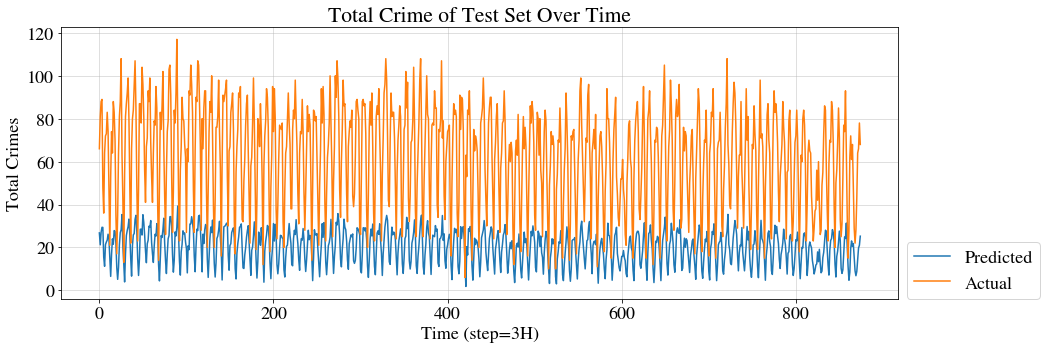

In [15]:
# Create model folder and setup logging for model
model_name = "Rolling Average"  # needs to be created
conf.model_name = model_name
model_path = data_path + f"models/{model_name}/"
conf.model_path = model_path
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")



# time step in this context is used for 
freqstr = t_range.freqstr
if freqstr == "H":
    freqstr = "1H"
time_step = int(24 / int(freqstr[:freqstr.find("H")]))
if time_step == 1:
    time_step = 7  # historic average to a week when time scale is daily

log.info(f"using time step: {time_step}")

test_set_size = data_group.testing_set.target_shape[0]

alpha=1e-2
window_len=1#time_step

ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)

all_crimes = data_group.crimes[:,0]
all_targets = data_group.targets
all_probas_pred = ma(all_crimes)
all_t_range = data_group.t_range

tst_probas_pred = all_probas_pred[-test_set_size:]
tst_targets = all_targets[-test_set_size:]
tst_t_range = all_t_range[-test_set_size:]

trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
trn_y_true = all_targets[time_step+1:-test_set_size]

thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

tst_y_true = tst_targets
tst_probas_pred = tst_probas_pred
tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)


# tst_y_pred = tst_y_true[:-1]
# tst_y_true = tst_y_true[1:]
# tst_probas_pred = tst_y_pred#tst_y_true + np.random.randn(*np.shape(tst_y_true))/10
    
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)  

log.info("=====================================END=====================================")

## Adding random noise to the predictions

In [ ]:
for noise_std in [0.4,0.8]:
    tst_crimes = data_group.testing_set.targets  # only mask the targets as the outputs


    noise = noise_std*np.random.randn(*np.shape(tst_crimes))
    # should be a flip seeing that the class distribution is so skew

    y_pred_sparse = tst_crimes + noise
    targets_dense = data_group.testing_set.targets
    y_pred_dense = y_pred_sparse

    probas_pred = y_pred_dense.flatten()
    
    N,L = targets_dense.shape
    targets_shape = N,L
    
    y_true = targets_dense.flatten()
    thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
    y_pred = np.copy(probas_pred)
    y_pred[y_pred >= thresh] = 1
    y_pred[y_pred < thresh] = 0

    noise_model_result = ModelResult(model_name=f"Noise model std={noise_std}",
                                    y_true=y_true,
                                    y_pred=y_pred,
                                    probas_pred=probas_pred,
                                    t_range=data_group.testing_set.t_range,
                                     shaper=data_group.shaper)

    model_results.append(noise_model_result)

In [ ]:
for result in model_results:
    print(result)

pr_plotter = PRCurvePlotter()
for result in model_results:
    pr_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
pr_plotter.show()
# pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
for result in model_results:
    roc_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
roc_plotter.show()
# roc_plotter.savefig(model_path + "plot_roc_curve.png")

In [ ]:
# todo create function do unflatten y_true, y_probs, and probas_true
# use shape of the model and just rnp.reshape



## [Hawkes Model](https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesSumExpKern.html)
does support multi variate but we are only using univariate for now
### Data Analysis Hawks-proces using the EM kernel

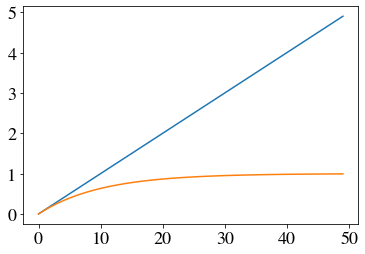

In [18]:
f = lambda x: 1 - np.exp(-1*x)
a = np.arange(0,5,.1)
plt.plot(a)
plt.plot(f(a))

In [ ]:
trn_inpt = data_group.training_set.crimes[:,0]
trn_trg = data_group.training_set.targets

tst_inpt = data_group.testing_set.crimes[:,0]
tst_trg = data_group.testing_set.targets


N,L = np.shape(trn_inpt)

model = IndHawkesModel(kernel_size=time_step*3 + 1)
trn_out = model.fit_transform(trn_inpt)
tst_out = model.transform(tst_inpt)

limit = 200
top_k = 10
i = 3000


# todo check how this influences the ROC and PR curves
def i2p(intensity):
    """
    intensity to probability
    """
    return 1 - np.exp(-1*intensity)
    
       
for i in range(top_k):
    for j in range(2):
        print(f"-------------------------------{j}----------------------------------")
        plt.figure(figsize=(10,2))
        plt.plot(tst_trg[i:i+limit,i])

        y_true = tst_trg[:,i]
        if j == 0:
            probas_pred = i2p(tst_out[:,i])
        else:     
            probas_pred = tst_out[:,i]

        thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
        y_pred = np.copy(probas_pred)
        y_pred[y_pred >= thresh] = 1
        y_pred[y_pred < thresh] = 0

        print(classification_report(y_true=y_true,y_pred=y_pred))

        plt.plot(y_pred[i:i+limit])
        plt.plot(probas_pred[i:i+limit])
    #     plt.ylim([0,1])
        plt.show()

        print(f"------------------------------------------------------------------")

        

In [ ]:
plt.plot(np.linspace(0,4,100))
plt.plot(i2p(np.linspace(0,4,100)))

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report

In [ ]:
for realization in realizations[:5]:#multi.timestamps:
    plt.figure(figsize=(10,1))
    for var in realization:
        plt.scatter(var, np.ones_like(var), alpha=.2, marker="|")    
    plt.show()

## sklearn dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy='prior')
dummy.fit(X,y)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X,y)

print("log_reg:",accuracy_score(y, lr.predict_proba(X)[:,1].round()))

for strat in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strat)
    dummy.fit(X,y)
    print(f"dummy ({strat}):",accuracy_score(y, dummy.predict_proba(X)[:,1].round())) 

## logistic regression model

In [ ]:
print(X.shape, y.shape)
get mean model as the starting position.
then train with only the new values to see the difference
print(data_group.crimes[:,0].shape)

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')

clf..fit(X, y)
clf.predict(X[:2, :])
clf.predict_proba(X[:2, :]) 
clf.score(X, y)

print(f"clf.coef_ -> {clf.coef_}")

plt.figure(figsize=(15,15))
X = data_group.crimes[:400,0,data_group.sorted_indices]
aspect = X.shape[1]/X.shape[0]

plt.imshow(X=X,aspect=aspect,cmap='viridis')
plt.show()
    